In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/ISBI2017/train/'
test_dir = '/content/drive/MyDrive/ISBI2017/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [5]:
import numpy as np
import random
from PIL import Image, ImageEnhance
import cv2

def augment_image(image):
    # Convert NumPy array to PIL image
    image = Image.fromarray(np.uint8(image))

    # Random Brightness Adjustment
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))

    # Random Contrast Adjustment
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))

    # Convert back to NumPy array
    image = np.array(image)

    # Random Horizontal Flip (50% chance)
    if random.random() > 0.5:
        image = cv2.flip(image, 1)  # Flip along the vertical axis (left-right)

    # Random Vertical Flip (50% chance)
    if random.random() > 0.5:
        image = cv2.flip(image, 0)  # Flip along the horizontal axis (up-down)

    # Random Rotation (-30 to 30 degrees)
    angle = random.uniform(-30, 30)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    image = cv2.warpAffine(image, M, (w, h))

    # Random Shearing (-20 to 20 degrees)
    shear_factor = random.uniform(-0.2, 0.2)
    M_shear = np.array([[1, shear_factor, 0], [shear_factor, 1, 0]])
    image = cv2.warpAffine(image, M_shear, (w, h))

    # Random Height & Width Shift
    max_shift = 10  # Maximum shift in pixels
    tx = random.randint(-max_shift, max_shift)  # Width shift
    ty = random.randint(-max_shift, max_shift)  # Height shift
    M_shift = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M_shift, (w, h))

    # Random Zoom (80% to 120%)
    scale = random.uniform(0.8, 1.2)
    image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

    # Resize back to original size
    image = cv2.resize(image, (w, h))

    # Normalize to [0, 1] range
    image = image / 255.0

    return image


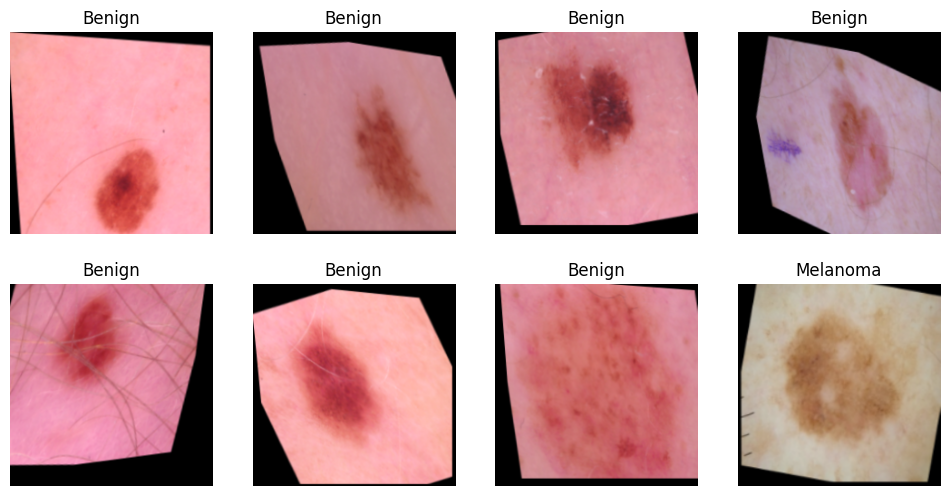

In [6]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

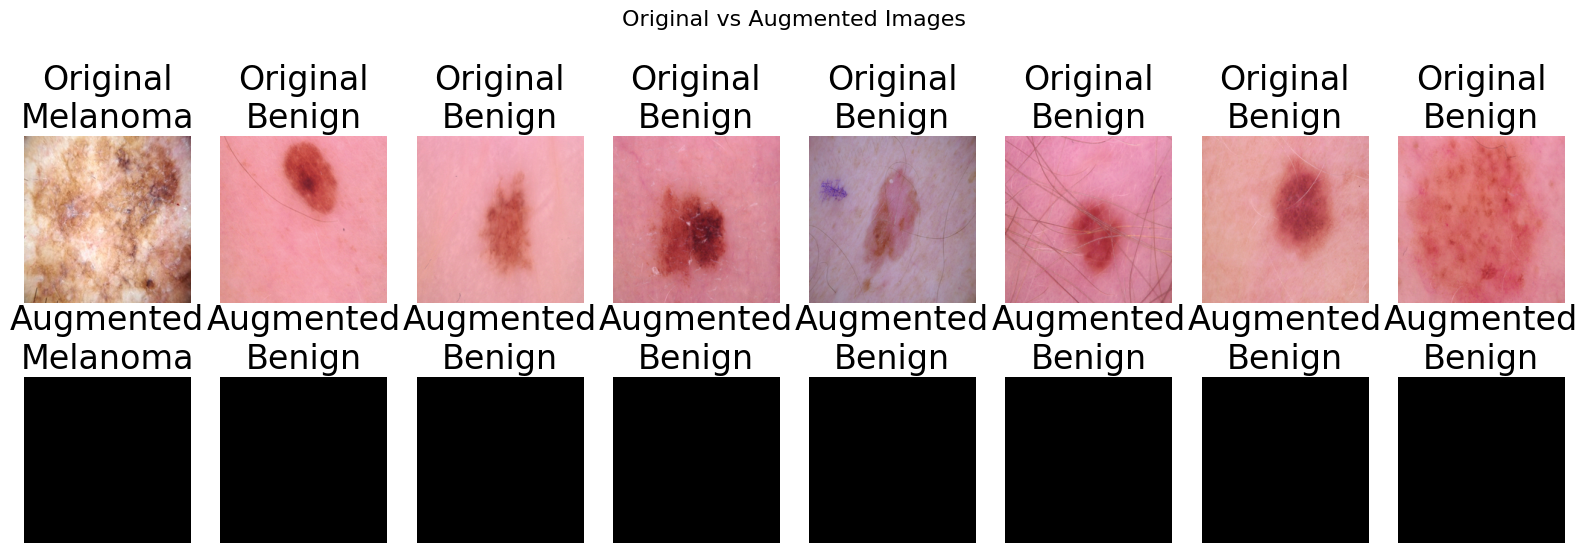

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMAGE_SIZE = 224

def open_images(paths, augment=False):
    '''
    Given a list of paths to images, this function returns the images as arrays.
    If augment=True, the images will be augmented.
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))  # Load original image
        image = img_to_array(image) / 255.0  # Convert to array and normalize

        if augment:
            image = augment_image(image)  # Apply augmentations

        images.append(image)

    return np.array(images)

# Load original and augmented images
original_images = open_images(train_paths[50:58], augment=False)  # Without augmentation
augmented_images = open_images(train_paths[50:58], augment=True)  # With augmentation
labels = train_labels[50:58]  # Corresponding labels

# Plot Original and Augmented Images
fig, axes = plt.subplots(2, 8, figsize=(16, 6))

for i in range(8):
    # Display original image
    axes[0, i].imshow(original_images[i])
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Original\n{labels[i]}")

    # Display augmented image
    axes[1, i].imshow(augmented_images[i])
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Augmented\n{labels[i]}")

plt.suptitle("Original vs Augmented Images", fontsize=16)
plt.tight_layout()
plt.show()


In [8]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [9]:
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [10]:

# Define the base model from VGG16
base_model = InceptionResNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable except the last few
for layer in base_model.layers:
    layer.trainable = False
# Set the last VGG block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Define the input layer explicitly
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Add the VGG16 base model
x = base_model(input_layer)

# Add additional layers
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(len(unique_labels), activation='softmax')(x)

# Define the full model
model = Model(inputs=input_layer, outputs=output_layer)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 5, 5, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,533,730 (208.03 MB)

 Trainable params: 3,393,410 (12.94 MB)

 Non-trainable params: 51,140,320 (195.08 MB)

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [13]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 20
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1119s 20s/step - loss: 0.4331 - sparse_categorical_accuracy: 0.7710
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - loss: 0.1421 - sparse_categorical_accuracy: 0.9466
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.9622
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0603 - sparse_categorical_accuracy: 0.9829
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9899
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 0.0241 - sparse_categorical_accuracy: 0.9963
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - loss: 0.0184 - sparse_categorical_accuracy: 0.9976
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.0128 - sparse_categorical_accuracy: 0.9994
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 0.0073 - sparse_categorical_accuracy: 1.0000
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms

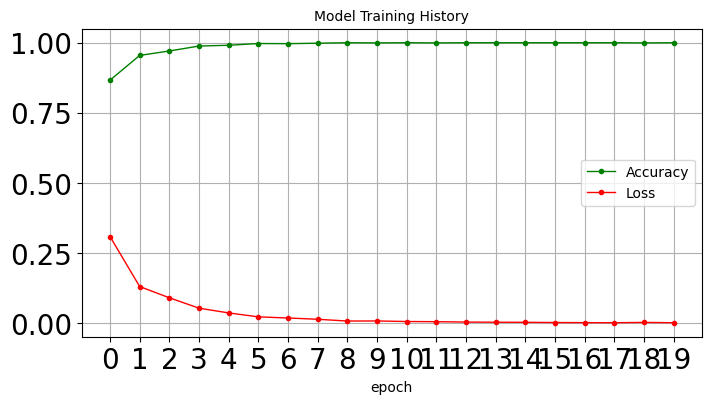

In [14]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=1)
plt.plot(history.history['loss'], '.r-', linewidth=1)
plt.title('Model Training History',fontsize =10)
plt.xlabel('epoch', fontsize =10)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='center right', fontsize =10)
plt.show()

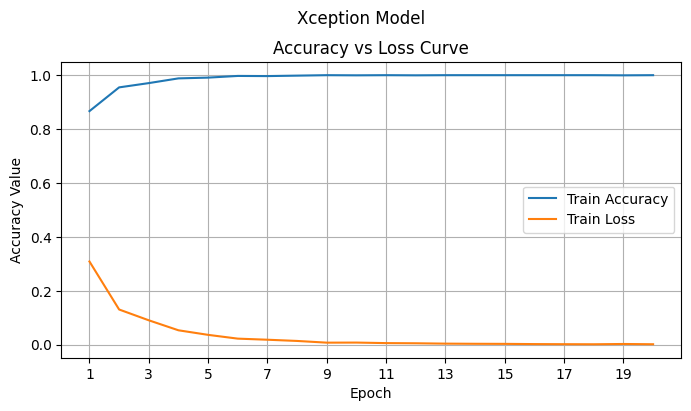

In [15]:
import matplotlib.pyplot as plt
plt.style.use('default')
f, ax1 = plt.subplots(figsize=(8, 4))
t = f.suptitle('Xception Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['sparse_categorical_accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['loss'], label='Train Loss')
ax1.grid()
ax1.set_xticks(np.arange(1, 21, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy vs Loss Curve')
l1 = ax1.legend(loc="best")

# Federated Learning Based transfer Learning enabled Xception Model

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 640ms/step - loss: 0.0041 - sparse_categorical_accuracy: 1.0000
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - loss: 0.0014 - sparse_categorical_accuracy: 1.0000
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 6.3902e-04 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 4.6659e-04 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 4.3836e-04 - sparse_categorical_accuracy: 1.0000
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 581ms/step - loss: 0.0041 - sparse_categorical_accuracy: 0.9982
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0012 - sparse_categorical_accuracy: 1.0000
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 5.3459e-04 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 4.1179e-04 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 14

  0%|          | 0/18 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


  6%|▌         | 1/18 [00:39<11:13, 39.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 11%|█         | 2/18 [01:07<08:43, 32.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 17%|█▋        | 3/18 [01:35<07:36, 30.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 22%|██▏       | 4/18 [02:02<06:47, 29.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 28%|██▊       | 5/18 [02:31<06:17, 29.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 33%|███▎      | 6/18 [02:58<05:41, 28.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 39%|███▉      | 7/18 [03:27<05:15, 28.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 44%|████▍     | 8/18 [03:54<04:42, 28.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 50%|█████     | 9/18 [04:22<04:11, 27.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 56%|█████▌    | 10/18 [04:48<03:40, 27.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 61%|██████    | 11/18 [05:18<03:16, 28.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 67%|██████▋   | 12/18 [05:43<02:43, 27.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 72%|███████▏  | 13/18 [06:10<02:15, 27.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 78%|███████▊  | 14/18 [06:37<01:48, 27.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 83%|████████▎ | 15/18 [07:06<01:23, 27.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 89%|████████▉ | 16/18 [07:33<00:54, 27.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 94%|█████████▍| 17/18 [08:03<00:28, 28.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


100%|██████████| 18/18 [08:30<00:00, 27.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


19it [09:04, 28.64s/it]


In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Benign       0.79      0.98      0.88       393
    Melanoma       0.95      0.50      0.66       207

    accuracy                           0.82       600
   macro avg       0.87      0.74      0.77       600
weighted avg       0.84      0.82      0.80       600



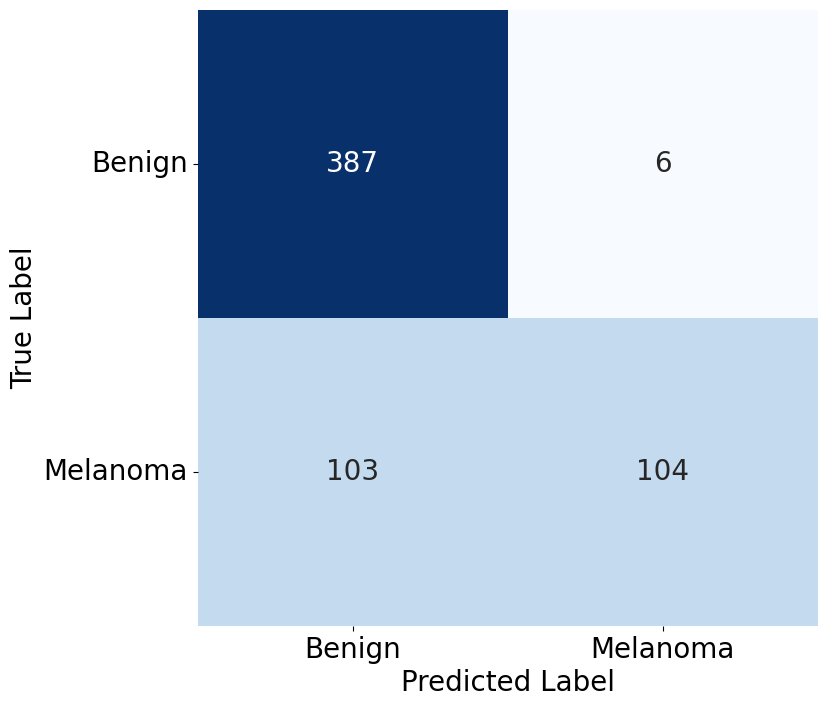

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()



In [19]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 104.000000 TN: 387.000000 FP: 6.000000 FN: 103.000000


In [20]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


acc: 0.81833
Specificity: 0.98473
 Recall: 0.50242
 Precision: 0.94545
F1 Score: 0.65615


In [21]:
import numpy as np
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)

# Compute MCC
mcc_score = matthews_corrcoef(y_true, y_pred)

# Compute Cohen’s Kappa
kappa_score = cohen_kappa_score(y_true, y_pred)

# Print Metrics
print(f"AUC: {auc_score:.5f}")
print(f"MCC: {mcc_score:.5f}")
print(f"Cohen's Kappa: {kappa_score:.5f}")


AUC: 0.74357
MCC: 0.59848
Cohen's Kappa: 0.54791


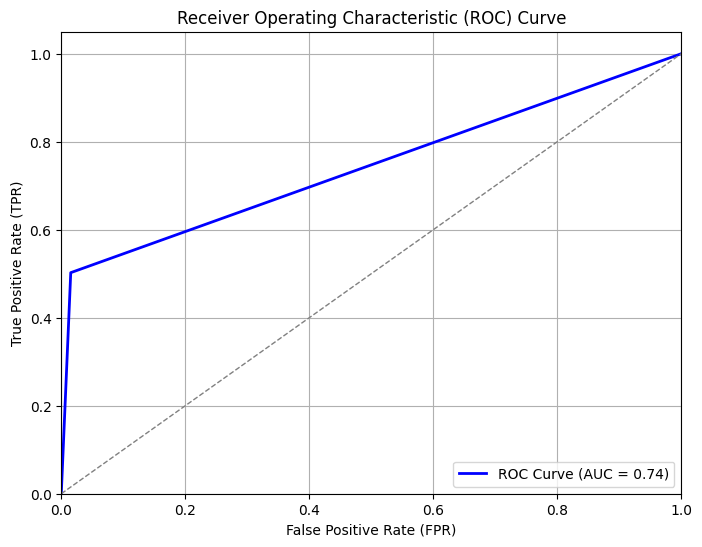

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()
